# Snake

In [1]:
# Environments
import environments_fully_observable 
import environments_partially_observable
from environments_fully_observable import OriginalSnakeEnvironment

# Training utilities
import numpy as np
from tqdm import trange
from tqdm.auto import tqdm
from dataclasses import dataclass
from typing import Tuple

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd

# Seed for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# Check for GPU availability (CUDA for Nvidia, MPS for Mac M1/M2/M3/M4)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✅ GPU Found: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ MPS (Metal Performance Shaders) Found: Apple Silicon Acceleration enabled.")
else:
    device = torch.device("cpu")
    print("❌ No GPU Found. Using CPU.")

✅ GPU Found: NVIDIA GeForce RTX 5050 Laptop GPU


## Environment definition

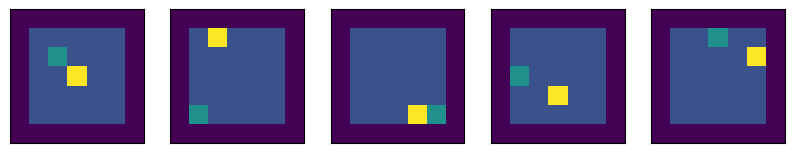

In [2]:
%matplotlib inline
# function to standardize getting an env for the whole notebook
def get_env(n=1000):
    # n is the number of boards that you want to simulate parallely
    # size is the size of each board, also considering the borders
    # mask for the partially observable, is the size of the local neighborhood
    size = 7
    e = environments_fully_observable.OriginalSnakeEnvironment(n, size)
    # or environments_partially_observable.OriginalSnakeEnvironment(n, size, 2)
    return e

env_ = get_env()

fig, axs = plt.subplots(1, min(len(env_.boards), 5), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board, origin="lower")

## Model DDQN

### Definition of the model and utilities.

For DDQN we define a Replay Buffer.

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.capacity = capacity
        self.buffer = []
        self.ptr = 0

    def store(self, state, action, reward, next_state, done):
        # Memorize transitions (handles batch of inputs)
        for i in range(len(state)):
            if len(self.buffer) < self.capacity:
                self.buffer.append(None)
            self.buffer[self.ptr] = (state[i], action[i], reward[i], next_state[i], done[i])
            self.ptr = (self.ptr + 1) % self.capacity # Circular buffer if full

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, ns, d = map(np.array, zip(*batch))
        return (
            torch.tensor(s, dtype=torch.float32, device=device),
            torch.tensor(a, dtype=torch.int64, device=device), # Int64 for actions (indices)
            torch.tensor(r, dtype=torch.float32, device=device).unsqueeze(1),
            torch.tensor(ns, dtype=torch.float32, device=device),
            torch.tensor(d, dtype=torch.float32, device=device).unsqueeze(1),
        )
    
    def __len__(self):
        return len(self.buffer)

We create a safety mask to force the agent avoiding actions that lead to walls. This speed up training.

In [ ]:
def get_safety_mask(env):
    # Give a mask (N, 4) where actions that would lead to collisions are -1e9
    masks = np.zeros((env.n_boards, 4), dtype=np.float32)
    # Find heads: (N, 3) -> [board_idx, x, y]
    heads = np.argwhere(env.boards == env.HEAD)
    
    # Directions (dx, dy) based on env.move: UP(0):+1x, RIGHT(1):+1y, DOWN(2):-1x, LEFT(3):-1y
    moves = {0: (1, 0), 1: (0, 1), 2: (-1, 0), 3: (0, -1)}
    
    for i, (b, hx, hy) in enumerate(heads):
        for action, (dx, dy) in moves.items():
            nx, ny = hx + dx, hy + dy
            # Check for collisions with WALLS (0) or BODY (3)
            if env.boards[b, nx, ny] == env.WALL or env.boards[b, nx, ny] == env.BODY:
                masks[b, action] = -1e9
    return torch.tensor(masks, device=device)

Create the CNN for the Q network.

In [ ]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        # Original input shape: (7, 7, 4) -> Channels: [Empty, Fruit, Body, Head]
        # PyTorch wants (N, C, H, W), so (N, 4, 7, 7)
        
        # Conv2D(32, (3, 3), padding="same")
        # In PyTorch, padding=1 on kernel 3x3 keeps spatial dimension (7x7)
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, padding=1)
        
        # Conv2D(64, (3, 3), activation="relu") -> no padding (valid)
        # 7x7 -> kernel 3 -> 5x5
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Flatten: 64 canali * 5 * 5 = 1600
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 4) # 4 Azioni

    def forward(self, x):
        # Convert x in (N, 4, 7, 7) for PyTorch
        x = x.permute(0, 3, 1, 2)
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        # Flatten
        x = x.reshape(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        return self.fc2(x) # Linear output (logits)

# Initialize Q-Network and Target Network
q = DQN().to(device)
value = DQN().to(device) # Target Network
value.load_state_dict(q.state_dict()) # copy weights
agent = q # Alias

## Training

Use Adam optimizer and reduce the number of active boards to focus the training and gather better data.

### Baseline + D3QN

In [ ]:
def baseline_policy(env):
    """
    Safe-Greedy Heuristic:
    1. Move toward the fruit if the move is safe.
    2. Otherwise choose the safe move that maximizes free space ahead.
    3. If no safe moves exist, pick a random move.
    """
    n = env.n_boards
    actions = np.zeros((n, 1), dtype=np.int32)

    # Get heads and fruits
    heads = np.argwhere(env.boards == env.HEAD)
    fruits = np.argwhere(env.boards == env.FRUIT)

    heads = heads[heads[:, 0].argsort()]
    fruits = fruits[fruits[:, 0].argsort()]

    # Directions
    moves = {0: (1, 0), 1: (0, 1), 2: (-1, 0), 3: (0, -1)}

    for i in range(n):
        b, hx, hy = heads[i]
        _, fx, fy = fruits[i]

        # Preferred moves (toward fruit)
        preferred = []
        if fx > hx: preferred.append(0)  # UP
        if fx < hx: preferred.append(2)  # DOWN
        if fy > hy: preferred.append(1)  # RIGHT
        if fy < hy: preferred.append(3)  # LEFT

        # Safety mask
        mask = get_safety_mask(env)[i].cpu().numpy()

        # 1. Try preferred safe moves
        for m in preferred:
            if mask[m] == 0:
                actions[i] = m
                break
        else:
            # 2. Choose safe move with most free space
            safe_moves = [m for m in range(4) if mask[m] == 0]

            if safe_moves:
                best_move = None
                best_space = -1

                for m in safe_moves:
                    dx, dy = moves[m]
                    nx, ny = hx + dx, hy + dy

                    # Count free space in that direction
                    space = 0
                    while env.boards[b, nx, ny] == env.EMPTY:
                        space += 1
                        nx += dx
                        ny += dy

                    if space > best_space:
                        best_space = space
                        best_move = m

                actions[i] = best_move

            else:
                # 3. No safe moves → random fallback
                actions[i] = np.random.randint(0, 4)

    return actions

def evaluate_baseline(steps=500):
    env = get_env(n=500)
    fruits = []

    for _ in range(steps):
        actions = baseline_policy(env)
        rewards = env.move(actions)
        rewards = rewards.numpy().flatten() if hasattr(rewards, "numpy") else rewards
        fruits.append(np.sum(rewards > 0.5))

    return np.array(fruits)

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import trange
import random

# ---------------------------------------------------
# 0. Utility: reset singola board
# ---------------------------------------------------
def reset_single_board(env, b):
    size = env.board_size

    board = np.ones((size, size)) * env.EMPTY
    board[[0, -1], :] = env.WALL
    board[:, [0, -1]] = env.WALL

    # HEAD
    available = np.argwhere(board == env.EMPTY)
    ind = available[np.random.choice(len(available))]
    board[ind[0], ind[1]] = env.HEAD

    # FRUIT
    available = np.argwhere(board == env.EMPTY)
    ind = available[np.random.choice(len(available))]
    board[ind[0], ind[1]] = env.FRUIT

    env.boards[b] = board
    env.bodies[b] = []

# ---------------------------------------------------
# 1. Safety mask (come prima)
# ---------------------------------------------------
def get_safety_mask(env):
    masks = np.zeros((env.n_boards, 4), dtype=np.float32)
    heads = np.argwhere(env.boards == env.HEAD)
    moves = {0: (1, 0), 1: (0, 1), 2: (-1, 0), 3: (0, -1)}

    for _, (b, hx, hy) in enumerate(heads):
        for action, (dx, dy) in moves.items():
            nx, ny = hx + dx, hy + dy
            # opzionale: controllo bounds
            if not (0 <= nx < env.board_size and 0 <= ny < env.board_size):
                masks[b, action] = -1e9
                continue
            if env.boards[b, nx, ny] == env.WALL or env.boards[b, nx, ny] == env.BODY:
                masks[b, action] = -1e9
    return torch.tensor(masks, device=device)

# ---------------------------------------------------
# 2. Architettura Dueling DQN potenziata
# ---------------------------------------------------
class DuelingDQN(nn.Module):
    def __init__(self, board_size=7): 
        super(DuelingDQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.fc_input_dim = 128 * 5 * 5 
        
        self.value_stream = nn.Sequential(
            nn.Linear(self.fc_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1) 
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(self.fc_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 4) 
        )

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.reshape(x.size(0), -1)
        val = self.value_stream(x)
        adv = self.advantage_stream(x)
        return val + (adv - adv.mean(dim=1, keepdim=True))

# ---------------------------------------------------
# 3. Baseline euristica safe-greedy
# ---------------------------------------------------
def baseline_policy(env):
    """
    Safe-Greedy Heuristic:
    1. Move toward the fruit if the move is safe.
    2. Otherwise choose the safe move that maximizes free space ahead.
    3. If no safe moves exist, pick a random move.
    """
    n = env.n_boards
    actions = np.zeros((n, 1), dtype=np.int32)

    heads = np.argwhere(env.boards == env.HEAD)
    fruits = np.argwhere(env.boards == env.FRUIT)

    heads = heads[heads[:, 0].argsort()]
    fruits = fruits[fruits[:, 0].argsort()]

    moves = {0: (1, 0), 1: (0, 1), 2: (-1, 0), 3: (0, -1)}
    mask_all = get_safety_mask(env).cpu().numpy()

    for i in range(n):
        b, hx, hy = heads[i]
        _, fx, fy = fruits[i]

        preferred = []
        if fx > hx: preferred.append(0)  # UP
        if fx < hx: preferred.append(2)  # DOWN
        if fy > hy: preferred.append(1)  # RIGHT
        if fy < hy: preferred.append(3)  # LEFT

        mask = mask_all[i]

        # 1. Preferred safe move
        chosen = None
        for m in preferred:
            if mask[m] == 0:
                chosen = m
                break

        if chosen is None:
            # 2. Safe move with max free space
            safe_moves = [m for m in range(4) if mask[m] == 0]
            if safe_moves:
                best_move = None
                best_space = -1
                for m in safe_moves:
                    dx, dy = moves[m]
                    nx, ny = hx + dx, hy + dy
                    space = 0
                    while (0 <= nx < env.board_size and 0 <= ny < env.board_size and
                           env.boards[b, nx, ny] == env.EMPTY):
                        space += 1
                        nx += dx
                        ny += dy
                    if space > best_space:
                        best_space = space
                        best_move = m
                chosen = best_move
            else:
                # 3. No safe moves → random fallback
                chosen = np.random.randint(0, 4)

        actions[i] = chosen

    return actions

def evaluate_baseline(steps=1000):
    env = get_env(n=500)
    fruits = []
    for _ in range(steps):
        actions = baseline_policy(env)
        rewards = env.move(actions)
        rewards = rewards.numpy().flatten() if hasattr(rewards, "numpy") else rewards
        fruits.append(np.sum(rewards > 0.5))
    return np.array(fruits)

# ---------------------------------------------------
# 4. Setup RL
# ---------------------------------------------------
NUM_BOARDS = 500 
env_ = get_env(n=NUM_BOARDS)

q = DuelingDQN().to(device)       
value = DuelingDQN().to(device)   
value.load_state_dict(q.state_dict())

optimizer = optim.Adam(q.parameters(), lr=1e-4)
replay_buffer = ReplayBuffer(capacity=200000) 

TOTAL_ITERATIONS = 10000
BATCH_SIZE = 512
GAMMA = 0.95
EPSILON = 1.0
MIN_EPSILON = 0.05
epsilon_decrement = (EPSILON - MIN_EPSILON) / (TOTAL_ITERATIONS * 0.7)

rl_rewards_history = []
moving_avg_history = []
window_size = 100 

fruits_history = []
wall_deaths_history = []
self_eat_history = []
avg_length_history = []
alive_ratio_history = []

# --- variabili per reward shaping ---
last_actions = np.full(NUM_BOARDS, -1, dtype=np.int32)
no_fruit_counter = np.zeros(NUM_BOARDS, dtype=np.int32)
fruit_streak = np.zeros(NUM_BOARDS, dtype=np.int32)

print("🚀 AVVIO TRAINING 'PURE ENV DESIGN'...")
print("Valori Env: Muro -1.0 | Frutto +1.0 | Step -0.01 | Self -0.5")

q.train()
state = env_.to_state()

# ---------------------------------------------------
# 5. Training loop
# ---------------------------------------------------
for iteration in trange(TOTAL_ITERATIONS, desc="Training"):
    
    # A. Mossa
    state_tensor = torch.tensor(state, device=device).float()
    mask = get_safety_mask(env_)
    
    if random.random() < EPSILON:
        actions_np = np.random.randint(0, 4, size=(NUM_BOARDS, 1)).astype(np.int32)
    else:
        with torch.no_grad():
            q_values = q(state_tensor)
            if iteration < 2000:
                actions = torch.argmax(q_values + mask, dim=1)
            else:
                actions = torch.argmax(q_values, dim=1)
            actions_np = actions.cpu().numpy().reshape(-1, 1)

    # 1. Esegui la mossa
    rewards_tensor = env_.move(actions_np)
    if hasattr(rewards_tensor, 'numpy'):
        rewards_np = rewards_tensor.numpy().flatten()
    else:
        rewards_np = np.array(rewards_tensor).flatten()
        
    # 2. Stato conseguente (anche se "morto")
    next_state_dead = env_.to_state()
    
    # 3. Reward puri
    raw_rewards = rewards_np.astype(np.float32)

    # --- REWARD SHAPING ---
    # 1) Survival bonus
    raw_rewards += 0.002

    # 2) Fruit eaten mask
    fruit_mask = (raw_rewards > 0.5)

    # 3) Fruit streak bonus
    fruit_streak[fruit_mask] += 1
    fruit_streak[~fruit_mask] = 0
    raw_rewards += 0.1 * fruit_streak

    # 4) Stagnation penalty
    no_fruit_counter[fruit_mask] = 0
    no_fruit_counter[~fruit_mask] += 1
    raw_rewards[no_fruit_counter > 20] -= 0.05

    # 5) Oscillation penalty
    current_actions = actions_np.flatten()
    opposite = {0:2, 2:0, 1:3, 3:1}
    osc_mask = np.array([
        (last_actions[i] == opposite.get(current_actions[i], -1))
        for i in range(NUM_BOARDS)
    ])
    raw_rewards[osc_mask] -= 0.03
    last_actions = current_actions.copy()

    # --- METRICHE ---
    fruits_eaten = np.sum(raw_rewards > 0.5)
    wall_deaths = np.sum(raw_rewards < -0.9)
    self_eat = np.sum((raw_rewards < -0.1) & (raw_rewards > -0.9))
    avg_length = np.mean([len(body) for body in env_.bodies])
    alive_ratio = 1.0 - (wall_deaths / NUM_BOARDS)

    fruits_history.append(fruits_eaten)
    wall_deaths_history.append(wall_deaths)
    self_eat_history.append(self_eat)
    avg_length_history.append(avg_length)
    alive_ratio_history.append(alive_ratio)

    # 4. Done (muro = morte)
    hit_wall = (rewards_np < -0.9)
    dones_np = hit_wall.astype(np.float32)

    # 5. Respawn manuale delle board morte
    dead_boards = np.where(hit_wall)[0]
    for b in dead_boards:
        reset_single_board(env_, b)

    # 6. Salviamo nel buffer la transizione "vera"
    replay_buffer.store(state, actions_np, raw_rewards, next_state_dead, dones_np)

    # 7. Stato per il prossimo step
    state = env_.to_state()
    
    # 8. Epsilon decay
    if EPSILON > MIN_EPSILON:
        EPSILON -= epsilon_decrement

    rl_rewards_history.append(np.mean(raw_rewards))

    # D. Learning
    if len(replay_buffer) > 5000:
        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(BATCH_SIZE)
        
        optimizer.zero_grad(set_to_none=True)
        current_q = q(b_s).gather(1, b_a)
        
        with torch.no_grad():
            next_q_online = q(b_ns)
            best_actions = torch.argmax(next_q_online, dim=1, keepdim=True)
            next_q_target = value(b_ns)
            double_q_value = next_q_target.gather(1, best_actions)
            target_v = b_r + (GAMMA * double_q_value * (1.0 - b_d))
        
        loss = F.smooth_l1_loss(current_q, target_v)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(q.parameters(), 10.0)
        optimizer.step()

    if iteration % 1000 == 0:
        value.load_state_dict(q.state_dict())

    # E. Monitor
    if iteration % 200 == 0 and iteration > 0:
        current_avg = np.mean(rl_rewards_history[-window_size:])
        moving_avg_history.append(current_avg)
        clear_output(wait=True)
        plt.figure(figsize=(14, 10))
        
        # Reward media
        plt.subplot(2, 2, 1)
        plt.plot(rl_rewards_history, alpha=0.15, color='gray')
        plt.plot(np.linspace(0, len(rl_rewards_history), len(moving_avg_history)),
                 moving_avg_history, color='orange', linewidth=2)
        plt.title(f"Reward media (iter {iteration})")
        plt.grid(True, alpha=0.3)

        # Frutti mangiati
        plt.subplot(2, 2, 2)
        plt.plot(fruits_history, color='green')
        plt.title("Frutti mangiati per iterazione")
        plt.grid(True, alpha=0.3)

        # Morti contro il muro
        plt.subplot(2, 2, 3)
        plt.plot(wall_deaths_history, color='red')
        plt.title("Morti contro il muro")
        plt.grid(True, alpha=0.3)

        # Lunghezza media del serpente
        plt.subplot(2, 2, 4)
        plt.plot(avg_length_history, color='blue')
        plt.title("Lunghezza media del serpente")
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

agent = q 
print("Training 'Pure Environment' completato.")
print("Frutti ultimi 500:", np.mean(fruits_history[-500:]))
print("Morti muro ultimi 500:", np.mean(wall_deaths_history[-500:]))
print("Lunghezza media ultimi 500:", np.mean(avg_length_history[-500:]))

# ---------------------------------------------------
# 6. Confronto finale RL vs baseline
# ---------------------------------------------------
baseline_fruits = evaluate_baseline(steps=1000)
baseline_value = np.mean(baseline_fruits)

window = 200
rl_moving = np.convolve(fruits_history, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10,5))
plt.plot(rl_moving, label="RL Agent (moving avg)", color="blue")
plt.axhline(y=baseline_value, color="orange", linestyle="--", label="Baseline (constant)")

plt.title("Learning Curve: Fruits per Iteration (RL vs Baseline)")
plt.xlabel("Training Iteration")
plt.ylabel("Fruits per Iteration")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Baseline average fruits per step: {baseline_value:.3f}")


### Ultimate version

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import trange
import random

# ---------------------------------------------------
# 0. Reset singola board
# ---------------------------------------------------
def reset_single_board(env, b):
    size = env.board_size

    board = np.ones((size, size)) * env.EMPTY
    board[[0, -1], :] = env.WALL
    board[:, [0, -1]] = env.WALL

    # HEAD
    available = np.argwhere(board == env.EMPTY)
    ind = available[np.random.choice(len(available))]
    board[ind[0], ind[1]] = env.HEAD

    # FRUIT
    available = np.argwhere(board == env.EMPTY)
    ind = available[np.random.choice(len(available))]
    board[ind[0], ind[1]] = env.FRUIT

    env.boards[b] = board
    env.bodies[b] = []

# ---------------------------------------------------
# 1. Safety mask
# ---------------------------------------------------
def get_safety_mask(env):
    masks = np.zeros((env.n_boards, 4), dtype=np.float32)
    heads = np.argwhere(env.boards == env.HEAD)
    moves = {0: (1, 0), 1: (0, 1), 2: (-1, 0), 3: (0, -1)}

    for _, (b, hx, hy) in enumerate(heads):
        for action, (dx, dy) in moves.items():
            nx, ny = hx + dx, hy + dy
            if not (0 <= nx < env.board_size and 0 <= ny < env.board_size):
                masks[b, action] = -1e9
                continue
            if env.boards[b, nx, ny] == env.WALL or env.boards[b, nx, ny] == env.BODY:
                masks[b, action] = -1e9
    return torch.tensor(masks, device=device)

# ---------------------------------------------------
# 2. Dueling DQN (potenziato ma semplice)
# ---------------------------------------------------
class DuelingDQN(nn.Module):
    def __init__(self, board_size=7): 
        super(DuelingDQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.fc_input_dim = 128 * 5 * 5 
        
        self.value_stream = nn.Sequential(
            nn.Linear(self.fc_input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1) 
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(self.fc_input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 4) 
        )

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.reshape(x.size(0), -1)
        val = self.value_stream(x)
        adv = self.advantage_stream(x)
        return val + (adv - adv.mean(dim=1, keepdim=True))

# ---------------------------------------------------
# 3. Baseline euristica safe-greedy
# ---------------------------------------------------
def baseline_policy(env):
    n = env.n_boards
    actions = np.zeros((n, 1), dtype=np.int32)

    heads = np.argwhere(env.boards == env.HEAD)
    fruits = np.argwhere(env.boards == env.FRUIT)

    heads = heads[heads[:, 0].argsort()]
    fruits = fruits[fruits[:, 0].argsort()]

    moves = {0: (1, 0), 1: (0, 1), 2: (-1, 0), 3: (0, -1)}
    mask_all = get_safety_mask(env).cpu().numpy()

    for i in range(n):
        b, hx, hy = heads[i]
        _, fx, fy = fruits[i]

        preferred = []
        if fx > hx: preferred.append(0)
        if fx < hx: preferred.append(2)
        if fy > hy: preferred.append(1)
        if fy < hy: preferred.append(3)

        mask = mask_all[i]

        # 1. Preferred safe move
        for m in preferred:
            if mask[m] == 0:
                actions[i] = m
                break
        else:
            # 2. Any safe move
            safe_moves = [m for m in range(4) if mask[m] == 0]
            if safe_moves:
                actions[i] = random.choice(safe_moves)
            else:
                actions[i] = np.random.randint(0, 4)

    return actions

def evaluate_baseline(steps=1000):
    env = get_env(n=500)
    fruits = []
    for _ in range(steps):
        actions = baseline_policy(env)
        rewards = env.move(actions)
        rewards = rewards.numpy().flatten() if hasattr(rewards, "numpy") else rewards
        fruits.append(np.sum(rewards > 0.5))
    return np.array(fruits)

# ---------------------------------------------------
# 4. Setup RL
# ---------------------------------------------------
NUM_BOARDS = 500 
env_ = get_env(n=NUM_BOARDS)

q = DuelingDQN().to(device)       
value = DuelingDQN().to(device)   
value.load_state_dict(q.state_dict())

optimizer = optim.Adam(q.parameters(), lr=1e-4)
replay_buffer = ReplayBuffer(capacity=200000) 

TOTAL_ITERATIONS = 10000
BATCH_SIZE = 512
GAMMA = 0.95
EPSILON = 1.0
MIN_EPSILON = 0.05
epsilon_decrement = (EPSILON - MIN_EPSILON) / (TOTAL_ITERATIONS * 0.7)

rl_rewards_history = []
fruits_history = []
wall_deaths_history = []
avg_length_history = []

rl_rewards_history = []
moving_avg_history = []
window_size = 100

fruits_history = []
wall_deaths_history = []
avg_length_history = []


# Reward shaping: solo anti-stagnazione
no_fruit_counter = np.zeros(NUM_BOARDS, dtype=np.int32)

print("🚀 Training RL Agent...")

q.train()
state = env_.to_state()

# ---------------------------------------------------
# 5. Training loop
# ---------------------------------------------------
for iteration in trange(TOTAL_ITERATIONS, desc="Training"):
    
    state_tensor = torch.tensor(state, device=device).float()
    mask = get_safety_mask(env_)

    # Epsilon-greedy
    if random.random() < EPSILON:
        actions_np = np.random.randint(0, 4, size=(NUM_BOARDS, 1)).astype(np.int32)
    else:
        with torch.no_grad():
            q_values = q(state_tensor)
            actions = torch.argmax(q_values + mask, dim=1)
            actions_np = actions.cpu().numpy().reshape(-1, 1)

    # Step
    rewards_tensor = env_.move(actions_np)
    rewards_np = rewards_tensor.numpy().flatten() if hasattr(rewards_tensor, "numpy") else np.array(rewards_tensor).flatten()
    next_state_dead = env_.to_state()

    raw_rewards = rewards_np.astype(np.float32)

    # --- Reward shaping minimale ---
    raw_rewards += 0.002  # survival bonus

    fruit_mask = (raw_rewards > 0.5)
    no_fruit_counter[fruit_mask] = 0
    no_fruit_counter[~fruit_mask] += 1
    raw_rewards[no_fruit_counter > 20] -= 0.05

    # Metriche
    fruits_history.append(np.sum(raw_rewards > 0.5))
    wall_deaths_history.append(np.sum(raw_rewards < -0.9))
    avg_length_history.append(np.mean([len(body) for body in env_.bodies]))

    # Done
    hit_wall = (rewards_np < -0.9)
    dones_np = hit_wall.astype(np.float32)

    # Respawn
    for b in np.where(hit_wall)[0]:
        reset_single_board(env_, b)

    # Store transition
    replay_buffer.store(state, actions_np, raw_rewards, next_state_dead, dones_np)

    # Next state
    state = env_.to_state()

    # Epsilon decay
    if EPSILON > MIN_EPSILON:
        EPSILON -= epsilon_decrement

    # Learning
    if len(replay_buffer) > 5000:
        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(BATCH_SIZE)
        
        optimizer.zero_grad(set_to_none=True)
        current_q = q(b_s).gather(1, b_a)
        
        with torch.no_grad():
            next_q_online = q(b_ns)
            best_actions = torch.argmax(next_q_online, dim=1, keepdim=True)
            next_q_target = value(b_ns)
            double_q_value = next_q_target.gather(1, best_actions)
            target_v = b_r + (GAMMA * double_q_value * (1.0 - b_d))
        
        loss = F.smooth_l1_loss(current_q, target_v)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(q.parameters(), 10.0)
        optimizer.step()

    if iteration % 1000 == 0:
        value.load_state_dict(q.state_dict())

        # ---------------------------------------------------
    # LIVE PLOTTING OGNI 200 ITERAZIONI
    # ---------------------------------------------------
    if iteration % 200 == 0 and iteration > 0:

        # Moving average del reward
        current_avg = np.mean(rl_rewards_history[-window_size:])
        moving_avg_history.append(current_avg)

        clear_output(wait=True)
        plt.figure(figsize=(14, 10))

        # 1. Reward medio
        plt.subplot(2, 2, 1)
        plt.plot(rl_rewards_history, alpha=0.15, color='gray')
        plt.plot(
            np.linspace(0, len(rl_rewards_history), len(moving_avg_history)),
            moving_avg_history,
            color='orange',
            linewidth=2
        )
        plt.title(f"Reward medio (iter {iteration})")
        plt.grid(True, alpha=0.3)

        # 2. Frutti mangiati
        plt.subplot(2, 2, 2)
        plt.plot(fruits_history, color='green')
        plt.title("Frutti mangiati per iterazione")
        plt.grid(True, alpha=0.3)

        # 3. Morti contro il muro
        plt.subplot(2, 2, 3)
        plt.plot(wall_deaths_history, color='red')
        plt.title("Morti contro il muro")
        plt.grid(True, alpha=0.3)

        # 4. Lunghezza media del serpente
        plt.subplot(2, 2, 4)
        plt.plot(avg_length_history, color='blue')
        plt.title("Lunghezza media del serpente")
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


agent = q
print("Training completato.")

# ---------------------------------------------------
# 6. Confronto RL vs baseline
# ---------------------------------------------------
baseline_fruits = evaluate_baseline(steps=1000)
baseline_value = np.mean(baseline_fruits)

window = 200
rl_moving = np.convolve(fruits_history, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10,5))
plt.plot(rl_moving, label="RL Agent (moving avg)", color="blue")
plt.axhline(y=baseline_value, color="orange", linestyle="--", label="Baseline")

plt.title("Learning Curve: Fruits per Iteration (RL vs Baseline)")
plt.xlabel("Training Iteration")
plt.ylabel("Fruits per Iteration")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Baseline average fruits per step: {baseline_value:.3f}")


Now we have trained the model and we can save the weights and reuse them.

In [ ]:
# Save weights of the online Q-network
torch.save(q.state_dict(), 'snake_ddqn_weights_new.pth')
print("Weights correctly saved!")

In [ ]:
# To reuse them later:

# 1. Create the model with the same architecture
q = DQN().to(device)

# 2. Load the weights
q.load_state_dict(torch.load('snake_ddqn_weights_new.pth', map_location=device))

# 3. Synchronize the target network
value = DQN().to(device)
value.load_state_dict(q.state_dict())

## Validation And Metrics

We use 3 metrics: 
1. Check if the agent has learnt how to behave (i.e., if it eats some fruits).
2. Check the average reward it gets from the environment.
3. Check if it actually accomplishes the task by running the policy for some steps.

In [ ]:
def test_agent(model, steps=200):
    model.eval() # Imposta il modello in modalità valutazione (no dropout, ecc.)
    
    # Create a new clean environment
    test_env = get_env(n=100) 
    state = test_env.to_state()
    
    total_rewards = 0
    fruits_eaten = 0
    
    # Execute for some steps without exploration (greedy)
    for _ in range(steps):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
        
        # Since we use a safety mask during training, we need it here too
        mask = get_safety_mask(test_env) 
        
        with torch.no_grad():
            # Just pure prediction (epsilon=0)
            q_values = model(state_tensor)
            
            # Apply the mask
            actions = torch.argmax(q_values + mask, dim=1)
            actions_np = actions.cpu().numpy().reshape(-1, 1)
        
        rewards_tensor = test_env.move(actions_np)
        state = test_env.to_state()
        
        # Statistics
        if hasattr(rewards_tensor, 'numpy'):
             r_np = rewards_tensor.numpy().flatten()
        else:
             r_np = np.array(rewards_tensor).flatten()
             
        total_rewards += np.sum(r_np)
        # Count how many times the reward is positive --> snake ate fruit
        fruits_eaten += np.sum(r_np > 0)

    avg_score = total_rewards / 100.0 # Average per board
    avg_fruits = fruits_eaten / 100.0
    
    print("--- TESTS RESULTS (on 100 parallel snakes) ---")
    print(f"Average Total Reward: {avg_score:.2f}")
    print(f"Average Fruits Eaten: {avg_fruits:.2f}")
    
    if avg_fruits > 1.0:
        print("✅ SUCCESS: Agent learnt how to play and seeks food!")
    elif avg_score > 0:
        print("⚠️ WARNING: Agent survives but eats little.")
    else:
        print("❌ FAILURE: Agent dies often or moves in circles.")

test_agent(agent)

In [ ]:
if 'rl_rewards_history' in locals() and len(rl_rewards_history) > 0:
    plt.figure(figsize=(12, 5))
    
    # Compute smoothed rewards for better visualization
    window = 50 # Describes the smooting window for the average
    data = np.array(rl_rewards_history)
    if len(data) >= window:
        smoothed = np.convolve(data, np.ones(window)/window, mode='valid')
        plt.plot(smoothed, label='Average Reward (Smoothed)')
    else:
        plt.plot(data, label='Average Reward')
        
    plt.title("Learning Curve")
    plt.xlabel("Iterations")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
def display_game(model, max_steps=100):
    # Create a single environment for visualization
    game_env = get_env(n=1) 
    state = game_env.to_state()
    frames = []
    
    # Save initial frame
    frames.append(game_env.boards[0].copy())
    
    print("Generating animation...", end="")
    
    # Mettiamo il modello in eval mode (buona norma in PyTorch)
    model.eval()
    
    # Game Loop
    for _ in range(max_steps):
        # Convertiamo in Tensor PyTorch e spostiamo sul device (GPU/MPS/CPU)
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
        
        # Use the mask for consistency (restituisce già un tensore sul device corretto)
        mask = get_safety_mask(game_env)
        
        # Greedy prediction
        with torch.no_grad(): # Disabilita il calcolo dei gradienti per l'inferenza
            q_values = model(state_tensor)
            
            # Argmax su dimensione 1
            actions = torch.argmax(q_values + mask, dim=1)
            
            # Convertiamo in numpy (importante: .cpu() se siamo su GPU/MPS)
            actions_np = actions.cpu().numpy().reshape(-1, 1)
        
        # Step
        game_env.move(actions_np)
        state = game_env.to_state()
        
        # Save the frame (copy necessary)
        frames.append(game_env.boards[0].copy())
        
        # If the game is over (only walls left or board reset), we could stop, but the environment
        # resets automatically, so we continue.

    # Setup animation
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.axis('off')
    
    # Color map:
    # 0=Wall, 1=Empty, 2=Fruit, 3=Body, 4=Head

    img = ax.imshow(frames[0], origin='lower', cmap='viridis', vmin=0, vmax=4)
    ax.set_title("Snake Agent Replay")

    # Animation update function
    def update(frame):
        img.set_array(frame)
        return [img]

    # Create video
    ani = animation.FuncAnimation(
        fig, 
        update, 
        frames=frames, 
        interval=100, # milliseconds between frames (lower = faster)
        blit=True
    )
    
    plt.close()
    return HTML(ani.to_jshtml())

# Execute the visualization for 500 steps
display_game(agent, max_steps=500)

### Benchmark


In [ ]:
def run_benchmark(agent_model, steps=500):
    print(f"Running Benchmark for {steps} steps...")
    
    env_ai = get_env(n=100)
    env_heur = get_env(n=100)
    
    state_ai = env_ai.to_state()
    
    # Metriche
    ai_rewards, heur_rewards = [], []
    ai_fruits, heur_fruits = [], []
    ai_wall, heur_wall = [], []
    ai_self, heur_self = [], []
    ai_len, heur_len = [], []
    
    agent_model.eval()
    
    for _ in range(steps):
        # === AI MOVE ===
        state_tensor = torch.tensor(state_ai, dtype=torch.float32, device=device)
        mask_ai = get_safety_mask(env_ai)
        
        with torch.no_grad():
            q_values = agent_model(state_tensor)
            actions_ai = torch.argmax(q_values + mask_ai, dim=1)
            actions_ai_np = actions_ai.cpu().numpy().reshape(-1, 1)
        
        rewards_ai = env_ai.move(actions_ai_np)
        state_ai = env_ai.to_state()
        
        # === HEURISTIC MOVE ===
        actions_heur_np = heuristic_policy(env_heur)
        rewards_heur = env_heur.move(actions_heur_np)
        
        # Convert rewards
        rewards_ai = rewards_ai.numpy() if hasattr(rewards_ai, "numpy") else rewards_ai
        rewards_heur = rewards_heur.numpy() if hasattr(rewards_heur, "numpy") else rewards_heur
        
        # === METRICHE ===
        ai_rewards.append(np.mean(rewards_ai))
        heur_rewards.append(np.mean(rewards_heur))
        
        ai_fruits.append(np.sum(rewards_ai > 0.5))
        heur_fruits.append(np.sum(rewards_heur > 0.5))
        
        ai_wall.append(np.sum(rewards_ai < -0.9))
        heur_wall.append(np.sum(rewards_heur < -0.9))
        
        ai_self.append(np.sum((rewards_ai < -0.1) & (rewards_ai > -0.9)))
        heur_self.append(np.sum((rewards_heur < -0.1) & (rewards_heur > -0.9)))
        
        ai_len.append(np.mean([len(b) for b in env_ai.bodies]))
        heur_len.append(np.mean([len(b) for b in env_heur.bodies]))
    
    return {
        "ai": {
            "reward": ai_rewards,
            "fruits": ai_fruits,
            "wall": ai_wall,
            "self": ai_self,
            "length": ai_len
        },
        "heur": {
            "reward": heur_rewards,
            "fruits": heur_fruits,
            "wall": heur_wall,
            "self": heur_self,
            "length": heur_len
        }
    }

res = run_benchmark(agent, steps=500)

plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.plot(res["ai"]["fruits"], label="AI", color="blue")
plt.plot(res["heur"]["fruits"], label="Heuristic", color="orange")
plt.title("Fruits per step")
plt.legend(); plt.grid(True)

plt.subplot(2,2,2)
plt.plot(res["ai"]["wall"], label="AI", color="blue")
plt.plot(res["heur"]["wall"], label="Heuristic", color="orange")
plt.title("Wall deaths per step")
plt.legend(); plt.grid(True)

plt.subplot(2,2,3)
plt.plot(res["ai"]["length"], label="AI", color="blue")
plt.plot(res["heur"]["length"], label="Heuristic", color="orange")
plt.title("Average snake length")
plt.legend(); plt.grid(True)

plt.subplot(2,2,4)
plt.plot(np.cumsum(res["ai"]["reward"]), label="AI", color="blue")
plt.plot(np.cumsum(res["heur"]["reward"]), label="Heuristic", color="orange")
plt.title("Cumulative reward")
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


## PPO Agent

In [3]:
NUM_BOARDS = 1000

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Environment wrapper
def make_env(n_boards=NUM_BOARDS, board_size=7):
    return OriginalSnakeEnvironment(n_boards=n_boards, board_size=board_size)

# Safety mask fuction: checks for unsafe moves for all boards
def get_safety_mask(env):
    masks = np.zeros((env.n_boards, 4), dtype=np.float32)
    heads = np.argwhere(env.boards == env.HEAD)
    heads = heads[heads[:, 0].argsort()]

    moves = {0:(1,0), 1:(0,1), 2:(-1,0), 3:(0,-1)}

    for b, hx, hy in heads:
        for a, (dx, dy) in moves.items():
            nx, ny = hx+dx, hy+dy
            if env.boards[b, nx, ny] in (env.WALL, env.BODY):
                masks[b, a] = 1.0   # unsafe
    return torch.tensor(masks, device=device)

Using device: cuda


Define the NN for the agent.

In [4]:
# PPO Network
class PPOActorCritic(nn.Module):
    def __init__(self, board_size=7, n_channels=4, n_actions=4):
        super().__init__()

        self.conv1 = nn.Conv2d(n_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.board_size = board_size
        conv_out_dim = 128 * board_size * board_size

        self.fc = nn.Linear(conv_out_dim, 256)
        self.policy_head = nn.Linear(256, n_actions)
        self.value_head = nn.Linear(256, 1)

    def forward(self, x) -> Tuple[torch.Tensor, torch.Tensor]:
        x = x.permute(0, 3, 1, 2)          # (N, H, W, C) -> (N, C, H, W)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc(x))

        logits = self.policy_head(x)
        value = self.value_head(x).squeeze(-1)
        return logits, value

    def act(self, x, mask=None):
        logits, value = self.forward(x)
        if mask is not None:
            logits = logits + mask
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        logprob = dist.log_prob(action)
        return action, logprob, value


    def evaluate_actions(self, x, actions):
        logits, values = self.forward(x)
        dist = torch.distributions.Categorical(logits=logits)
        logprobs = dist.log_prob(actions)
        entropy = dist.entropy()
        return logprobs, entropy, values


In [5]:
# Rollout buffer for PPO
@dataclass
class RolloutBuffer:
    obs: list
    actions: list
    logprobs: list
    rewards: list
    dones: list
    values: list

    def __init__(self):
        self.obs = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.dones = []
        self.values = []

    def add(self, obs, action, logprob, reward, done, value):
        # obs, reward, done, value, logprob, action are numpy or scalars
        self.obs.append(obs)
        self.actions.append(action)
        self.logprobs.append(logprob)
        self.rewards.append(reward)
        self.dones.append(done)
        self.values.append(value)

    def to_tensors(self):
        # conver all to torch tensors
        obs = torch.tensor(np.array(self.obs), dtype=torch.float32, device=device)
        actions = torch.tensor(np.array(self.actions), dtype=torch.long, device=device)
        logprobs = torch.tensor(np.array(self.logprobs), dtype=torch.float32, device=device)
        rewards = torch.tensor(np.array(self.rewards), dtype=torch.float32, device=device)
        dones = torch.tensor(np.array(self.dones), dtype=torch.float32, device=device)
        values = torch.tensor(np.array(self.values), dtype=torch.float32, device=device)
        return obs, actions, logprobs, rewards, dones, values

# GAE advantage computation
def compute_gae(rewards, dones, values, last_value, gamma=0.99, lam=0.95):
    """
    rewards, dones, values: shape (T, N)
    last_value: shape (N,)
    Everything on the correct device.
    """
    T, N = rewards.shape
    advantages = torch.zeros(T, N, device=device)
    gae = torch.zeros(N, device=device)

    for t in reversed(range(T)):
        mask = 1.0 - dones[t]  # 0 se done, 1 altrimenti
        next_value = last_value if t == T - 1 else values[t + 1]
        delta = rewards[t] + gamma * next_value * mask - values[t]
        gae = delta + gamma * lam * mask * gae
        advantages[t] = gae

    returns = advantages + values
    return advantages, returns

# PPO Agent
class PPOAgent:
    def __init__(
        self,
        board_size=7,
        n_actions=4,
        lr=4e-4,
        gamma=0.99,
        lam=0.95,
        clip_eps=0.2,
        epochs=4,
        batch_size=1024,
        ent_coef=0.05,   
    ):
        self.gamma = gamma
        self.lam = lam
        self.clip_eps = clip_eps
        self.epochs = epochs
        self.batch_size = batch_size
        self.ent_coef = ent_coef

        self.net = PPOActorCritic(board_size=board_size, n_channels=4, n_actions=n_actions).to(device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)

    def update(self, buffer: RolloutBuffer, last_value):
        # Move last_value to device
        last_value = last_value.to(device)

        obs, actions, old_logprobs, rewards, dones, values = buffer.to_tensors()

        # obs: (T, N, H, W, C)
        T, N = rewards.shape
        obs = obs.view(T * N, *obs.shape[2:])
        actions = actions.view(T * N)
        old_logprobs = old_logprobs.view(T * N)
        rewards = rewards.view(T, N)
        dones = dones.view(T, N)
        values = values.view(T, N)
        last_value = last_value.view(N)

        advantages, returns = compute_gae(
            rewards, dones, values, last_value,
            gamma=self.gamma, lam=self.lam
        )

        advantages = advantages.view(T * N)
        returns = returns.view(T * N)

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # PPO update
        dataset_size = T * N
        idxs = np.arange(dataset_size)

        for _ in range(self.epochs):
            np.random.shuffle(idxs)
            for start in range(0, dataset_size, self.batch_size):
                end = start + self.batch_size
                batch_idx = idxs[start:end]

                batch_obs = obs[batch_idx]
                batch_actions = actions[batch_idx]
                batch_old_logprobs = old_logprobs[batch_idx]
                batch_adv = advantages[batch_idx]
                batch_returns = returns[batch_idx]

                logprobs, entropy, values_pred = self.net.evaluate_actions(batch_obs, batch_actions)

                ratio = torch.exp(logprobs - batch_old_logprobs)
                surr1 = ratio * batch_adv
                surr2 = torch.clamp(ratio, 1.0 - self.clip_eps, 1.0 + self.clip_eps) * batch_adv
                policy_loss = -torch.min(surr1, surr2).mean()

                value_loss = F.mse_loss(values_pred, batch_returns)

                loss = policy_loss + 0.5 * value_loss - self.ent_coef * entropy.mean()

                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.net.parameters(), 0.5)
                self.optimizer.step()

# Training loop PPO
def train_ppo(total_steps=2_000_000, n_boards=256, board_size=7, rollout_horizon=256):
    env = make_env(n_boards=n_boards, board_size=board_size)
    agent = PPOAgent(board_size=board_size)

    state = env.to_state()  # (N, H, W, C) NumPy
    step_count = 0

    reward_history = []
    fruits_history = []
    wall_deaths_history = []

    pbar = tqdm(total=total_steps, desc="Training PPO")
    while step_count < total_steps:
        buffer = RolloutBuffer()

        # Rollout of length T = rollout_horizon
        # changing the rollout affects the memory and the discovery of new states
        for t in range(rollout_horizon):
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
            mask_tensor = get_safety_mask(env)
            penalty = -1.0

            with torch.no_grad():
                logits, values = agent.net.forward(state_tensor)
                logits = logits + penalty * mask_tensor
                dist = torch.distributions.Categorical(logits=logits)
                actions = dist.sample()
                logprobs = dist.log_prob(actions)

            actions_np = actions.cpu().numpy().reshape(-1, 1)
            rewards_tensor = env.move(actions_np)          
            rewards_np = rewards_tensor.cpu().numpy().flatten()

            next_state = env.to_state()

            # done = 1 (HIT_WALL_REWARD)
            #dones_np = np.isin(rewards_np, [env.HIT_WALL_REWARD]).astype(np.float32)
            dones_np = np.zeros(n_boards, dtype=np.float32)


            # metrics
            reward_history.append(np.mean(rewards_np))
            fruits_history.append(np.sum(rewards_np == env.FRUIT_REWARD))
            wall_deaths_history.append(np.sum(rewards_np == env.HIT_WALL_REWARD))

            buffer.add(
                obs=state,                          # NumPy (N, H, W, C)
                action=actions_np.squeeze(-1),      # NumPy (N,)
                logprob=logprobs.cpu().numpy(),     # NumPy (N,)
                reward=rewards_np,                  # NumPy (N,)
                done=dones_np,                      # NumPy (N,)
                value=values.cpu().numpy()          # NumPy (N,)
            )

            state = next_state
            step_count += n_boards
            pbar.update(n_boards)

            if step_count >= total_steps:
                break

        # Bootstrap value for last_state
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
        with torch.no_grad():
            _, last_values = agent.net.forward(state_tensor)
        agent.update(buffer, last_values)

        # Logging
        if len(reward_history) > 0 and (step_count // n_boards) % 50 == 0:
            print(
                f"Steps: {step_count} | "
                f"Avg reward last 500: {np.mean(reward_history[-500:]):.3f} | "
                f"Fruits last 500: {np.mean(fruits_history[-500:]):.2f} | "
                f"Wall deaths last 500: {np.mean(wall_deaths_history[-500:]):.2f}"
            )

    pbar.close()
    return agent, reward_history, fruits_history, wall_deaths_history


In [6]:
# Train the PPO agent on NUM_BOARDS parallel boards

# Good with rollout_horizon=256 and entropy_coeff=0.05

agent, rew_hist, fruits_hist, wall_hist = train_ppo(
    total_steps=5_000_000,
    n_boards=NUM_BOARDS,
    board_size=7,
    rollout_horizon=256
)

Training PPO:   0%|          | 0/5000000 [00:00<?, ?it/s]

Steps: 5000000 | Avg reward last 500: 0.363 | Fruits last 500: 260.02 | Wall deaths last 500: 0.06


In [13]:
# Save the trained weights
torch.save(agent.net.state_dict(), "ppo_snake_weights.pth")

In [8]:
def baseline_policy(env):
    n = env.n_boards
    actions = np.zeros((n, 1), dtype=np.int32)

    heads = np.argwhere(env.boards == env.HEAD)
    fruits = np.argwhere(env.boards == env.FRUIT)

    heads = heads[heads[:, 0].argsort()]
    fruits = fruits[fruits[:, 0].argsort()]

    mask_all = get_safety_mask(env).cpu().numpy()

    # moves: 0=down,1=right,2=up,3=left
    for i in range(n):
        b, hx, hy = heads[i]
        _, fx, fy = fruits[i]

        # greedy preferences
        preferred = []
        if fx > hx: preferred.append(0)
        if fx < hx: preferred.append(2)
        if fy > hy: preferred.append(1)
        if fy < hy: preferred.append(3)

        mask = mask_all[i]

        # 1. Try greedy safe moves
        safe_preferred = [m for m in preferred if mask[m] == 0]
        if safe_preferred:
            actions[i] = random.choice(safe_preferred)
            continue

        # 2. Try any safe move
        safe_moves = [m for m in range(4) if mask[m] == 0]
        if safe_moves:
            actions[i] = random.choice(safe_moves)
            continue

        # 3. No safe moves -> choose randomly (like PPO can)
        actions[i] = np.random.randint(0, 4)

    return actions



In [9]:
# To assess the performance after training, we evaluate the baseline and the PPO agent on 1000 steps and compare the average reward, fruits, and deaths. 

def evaluate_baseline(steps=1000):
    env = get_env(n=NUM_BOARDS)
    fruits = []
    deaths = []
    reward_means = []

    for _ in range(steps):
        actions = baseline_policy(env)
        rewards = env.move(actions)
        rewards = rewards.numpy().flatten() if hasattr(rewards, "numpy") else rewards

        # metriche
        fruits.append(np.sum(rewards == env.FRUIT_REWARD))
        deaths.append(np.sum(rewards == env.HIT_WALL_REWARD))
        reward_means.append(np.mean(rewards))

    return (
        np.array(fruits),
        np.array(deaths),
        np.array(reward_means)
    )

baseline_fruits, baseline_deaths, baseline_reward = evaluate_baseline(steps=1000)
baseline_reward_avg = np.mean(baseline_reward)
baseline_fruits_avg = np.mean(baseline_fruits)
baseline_deaths_avg = np.mean(baseline_deaths)

def evaluate_agent(agent, steps=1000):
    env = get_env(n=NUM_BOARDS)
    fruits = []
    deaths = []
    rewards_mean = []

    for _ in range(steps):
        state = env.to_state()
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)

        with torch.no_grad():
            logits, _ = agent.net(state_tensor)
            dist = torch.distributions.Categorical(logits=logits)
            actions = dist.sample().cpu().numpy().reshape(-1, 1)

        rewards = env.move(actions).cpu().numpy().flatten()

        fruits.append(np.sum(rewards == env.FRUIT_REWARD))
        deaths.append(np.sum(rewards == env.HIT_WALL_REWARD))
        rewards_mean.append(np.mean(rewards))

    return (
        np.array(fruits),
        np.array(deaths),
        np.array(rewards_mean)
    )

ppo_fruits_eval, ppo_deaths_eval, ppo_reward_eval = evaluate_agent(agent, steps=1000)

df = pd.DataFrame({
    "Metric": ["Reward per Step", "Fruits per Step", "Deaths per Step"],
    "PPO": [
        np.mean(ppo_reward_eval),
        np.mean(ppo_fruits_eval),
        np.mean(ppo_deaths_eval)
    ],
    "Baseline": [
        baseline_reward_avg,
        baseline_fruits_avg,
        baseline_deaths_avg
    ]
})


display(df)


,Metric,PPO,Baseline
0,Reward per Step,0.366892,0.294518
1,Fruits per Step,264.181000,229.307000
2,Deaths per Step,0.115000,11.661000


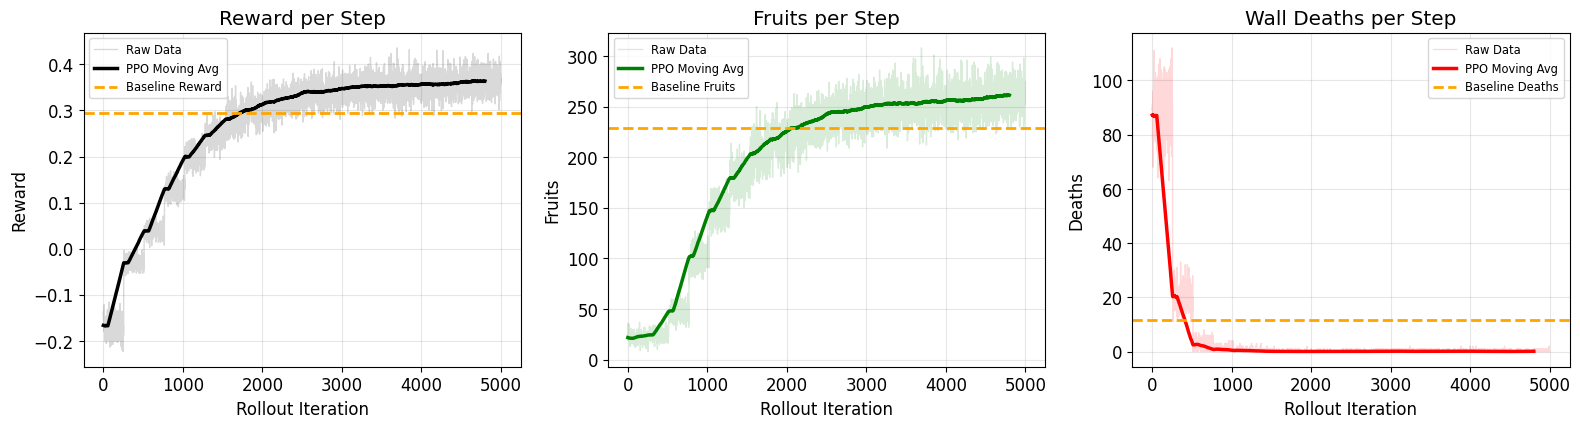

In [10]:
# EVALUATION DURING TRAINING OF PPO AGENT 
# We just consider the rollouts during training because they are already collected and give a good idea of the learning curve. 
# We compute the moving average of reward, fruits, and deaths during training and compare them with the baseline averages.
# Baseline evaluation is done in the above cell.

window = 200
kernel = np.ones(window) / window

# Moving averages PPO
reward_moving = np.convolve(rew_hist, kernel, mode='valid')
fruits_moving = np.convolve(fruits_hist, kernel, mode='valid')
deaths_moving = np.convolve(wall_hist, kernel, mode='valid')


plt.figure(figsize=(16, 12))
plt.rcParams.update({'font.size': 12})

# Reward per step
plt.subplot(3, 3, 1)
plt.plot(rew_hist, color='black', alpha=0.15, linewidth=1, label="Raw Data")
plt.plot(reward_moving, color='black', linewidth=2.5, label="PPO Moving Avg")
plt.axhline(y=baseline_reward_avg, color='orange', linestyle='--', linewidth=2,
            label=f"Baseline Reward")
plt.title("Reward per Step")
plt.xlabel("Rollout Iteration")
plt.ylabel("Reward")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

# Fruits per step
plt.subplot(3, 3, 2)
plt.plot(fruits_hist, color='green', alpha=0.15, linewidth=1, label="Raw Data")
plt.plot(fruits_moving, color='green', linewidth=2.5, label="PPO Moving Avg")
plt.axhline(y=baseline_fruits_avg, color='orange', linestyle='--', linewidth=2,
            label=f"Baseline Fruits")
plt.title("Fruits per Step")
plt.xlabel("Rollout Iteration")
plt.ylabel("Fruits")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

# Wall deaths per step
plt.subplot(3, 3, 3)
plt.plot(wall_hist, color='red', alpha=0.15, linewidth=1, label="Raw Data")
plt.plot(deaths_moving, color='red', linewidth=2.5, label="PPO Moving Avg")
plt.axhline(y=baseline_deaths_avg, color='orange', linestyle='--', linewidth=2,
            label=f"Baseline Deaths")
plt.title("Wall Deaths per Step")
plt.xlabel("Rollout Iteration")
plt.ylabel("Deaths")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Play Snake with PPO Agent

In [ ]:
# Load the trained model
agent = PPOAgent(board_size=7, n_actions=4)
agent.net.load_state_dict(torch.load("ppo_snake_weights.pth"))
agent.net.eval()

In [11]:
def display_game(model, max_steps=100):
    # Create a single environment for visualization
    game_env = get_env(n=1)
    state = game_env.to_state()
    frames = []

    frames.append(game_env.boards[0].copy())

    print("Generating animation...", end="")

    model.eval()

    for _ in range(max_steps):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)

        # Safety mask
        mask = get_safety_mask(game_env)

        with torch.no_grad():
            logits, _ = model(state_tensor)
            logits = logits + mask * -1.0
            actions = torch.argmax(logits, dim=1)

        actions_np = actions.cpu().numpy().reshape(-1, 1)

        game_env.move(actions_np)
        state = game_env.to_state()

        frames.append(game_env.boards[0].copy())

    # -----------------------------------------
    # 1. STATIC SNAPSHOTS EVERY 15 STEPS
    # -----------------------------------------
    snapshot_steps = [0, 10, 20, 30, 40]
    snapshot_steps = [s for s in snapshot_steps if s < len(frames)]

    fig, axes = plt.subplots(1, len(snapshot_steps), figsize=(15, 3))

    for ax, step in zip(axes, snapshot_steps):
        ax.imshow(frames[step], origin='lower', cmap='viridis', vmin=0, vmax=4)
        ax.set_title(f"Step {step}")
        ax.axis('off')

    plt.show()

    # -----------------------------------------
    # 2. ANIMATION
    # -----------------------------------------
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.axis('off')

    img = ax.imshow(frames[0], origin='lower', cmap='viridis', vmin=0, vmax=4)
    ax.set_title("Snake Agent Replay")

    def update(frame):
        img.set_array(frame)
        return [img]

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=frames,
        interval=100,
        blit=True
    )

    plt.close()
    return HTML(ani.to_jshtml())


Generating animation...

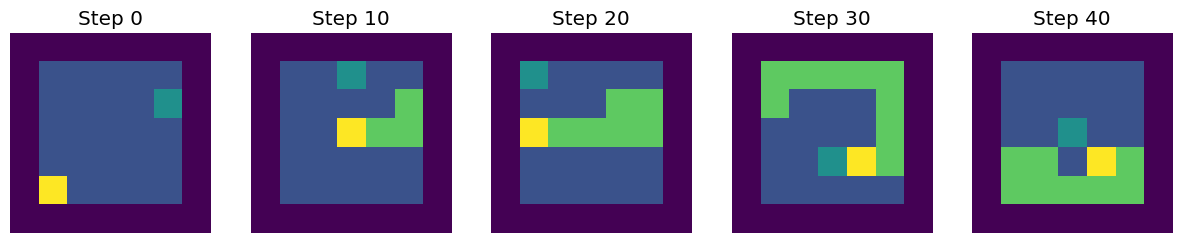

In [12]:
display_game(agent.net, max_steps=200)